# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Load the Digit Data

We have processed the image with Min-Max scaling, then binarized it at a threshold of 0.4. Convert the labels into two one-hot-encoding. 

In [ ]:
# Load the 8x8 digits dataset
digits = datasets.load_digits()
print('labels:', set(digits.target))

# selecting image from 1 to 9
mask = (digits.target >= 1) & (digits.target <= 9)
X = digits.data[mask]
y = digits.target[mask]

# Convert labels (1-9) to indices (0-8)
y = y - 1  

# Compute the two components for OHE
value1 = y // 3  # First OHE index (0,1,2)
value2 = y % 3   # Second OHE index (0,1,2)

# Create two one-hot encoded matrices
ohe1 = np.zeros((len(y), 3))  # First OHE array (N, 3)
ohe2 = np.zeros((len(y), 3))  # Second OHE array (N, 3)

ohe1[np.arange(len(y)), value1] = 1
ohe2[np.arange(len(y)), value2] = 1
merged_ohe = np.concatenate((ohe1, ohe2), axis=1)

def load_images_from_folder(folder, label, image_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=image_size, color_mode="grayscale")  # Convert to grayscale
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = img_array.flatten()  # Flatten to 1D vector
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)
    
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_scaled = scaler.fit_transform(X)
# Apply thresholding
X_binary = (X_scaled > 0.4).astype(int)


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, merged_ohe, test_size=0.2, random_state=42
)

labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# Ploted a sample image with labels

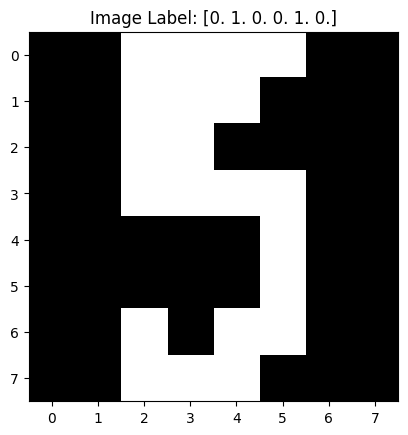

In [33]:
plt.imshow(X_test[11].reshape(8, 8), cmap='gray')
plt.title(f"Image Label: {y_test[11]}")
plt.savefig("1.png")
plt.show()

# DNA Computation Network

1. First 6 distributed layers
2. Two WTA layers

In [ ]:
class dna_computational_network:
    def __init__(self, input_size, 
                 distributed_calculation=6, 
                 wta_layers=2,
                 competitive_signal_per_wta=3,
                 threshold=0.05, learning_rate=0.1, 
                 num_labels=9):

        np.random.seed(42)
        self.input_size = input_size
        self.weights_wta = {}
        self.distributed_calculation = distributed_calculation
        self.wta_layers = wta_layers
        self.competitive_signal_per_wta = competitive_signal_per_wta
        self.net_competitive_signal = wta_layers * competitive_signal_per_wta
        
        # Initialize weights randomly
        self.weights = np.random.rand(self.distributed_calculation, input_size)

        for layer in range(1, self.wta_layers + 1):
            self.weights_wta[f"weights_{layer}"] = np.random.rand(self.distributed_calculation, 
                                                                  self.competitive_signal_per_wta)
        
        self.num_labels = num_labels
        self.threshold = threshold  # Set a threshold for activation
        self.learning_rate = learning_rate  # Learning rate for weight updates
        self.lowest_loss = float('inf')

        # Store the best weights
        self.best_weights = self.weights.copy()
        self.best_weights_wta = {key: value.copy() for key, value in self.weights_wta.items()}
        
        
    def weighted_activation(self, output):
        # return (output/self.input_size >= self.threshold).astype(int)
        return output/64
    
    def wta_activation(self, weighted_sum_array):
        ohe_output = np.zeros(len(weighted_sum_array))
        ohe_output[np.argmax(weighted_sum_array)] = 1  # Set only one neuron to 1 (WTA)
        return ohe_output
    
    def distributed_layes(self, X):
        return self.weighted_activation(np.dot(self.weights, X))    
    
    def wta_layer(self, distributed_output, layer):
        return self.wta_activation(np.dot(distributed_output, self.weights_wta[f"weights_{layer}"]))
    
    def convert_wta_label(self, ohe1, ohe2):
        value1 = np.argmax(ohe1)  # Get index of max value in ohe1 (0,1,2)
        value2 = np.argmax(ohe2)  # Get index of max value in ohe2 (0,1,2)
    
        label = (value1 * 3) + value2 + 1
        label_ohe = np.zeros(self.num_labels)  # Create OHE vector
        label_ohe[label - 1] = 1 
        return label_ohe
    
    def forward(self, X):
        distributed_output = self.distributed_layes(X)
        layer_1_output = self.wta_layer(distributed_output, 1)
        layer_2_output = self.wta_layer(distributed_output, 2)
        return np.concatenate([layer_1_output, layer_2_output])
    
    def train(self, X_train, y_train, epochs=100):
        for epoch in range(epochs):
            total_loss = 0
            
            for X, y_true in zip(X_train, y_train):
                # Forward pass
                distributed_output = self.distributed_layes(X)
                # print(distributed_output)
                # break
                layer_1_output = self.wta_layer(distributed_output, 1)
                layer_2_output = self.wta_layer(distributed_output, 2)
                
                y_pred = np.concatenate([layer_1_output, layer_2_output])
                
                # Compute error
                error = y_true - y_pred
                
                # Compute gradients (Backpropagation)
                # 1️⃣ Update WTA Weights
                grad_wta_1 = np.outer(distributed_output, error[:self.competitive_signal_per_wta]) 
                grad_wta_2 = np.outer(distributed_output, error[self.competitive_signal_per_wta:])  
                
                self.weights_wta["weights_1"] += self.learning_rate * grad_wta_1  
                self.weights_wta["weights_2"] += self.learning_rate * grad_wta_2  
                
                # Clip WTA Weights
                self.weights_wta["weights_1"] = np.clip(self.weights_wta["weights_1"], 0, 1)
                self.weights_wta["weights_2"] = np.clip(self.weights_wta["weights_2"], 0, 1)
    
                # 2️⃣ Update Distributed Layer Weights
                error_distributed = (error[:self.competitive_signal_per_wta] @ self.weights_wta["weights_1"].T) + \
                                    (error[self.competitive_signal_per_wta:] @ self.weights_wta["weights_2"].T)
    
                # print(error_distributed)
                # print(error)
                # print(self.weights_wta["weights_1"], self.weights_wta["weights_2"])
                # break
                grad_dist = np.outer(error_distributed, X)  
                self.weights += self.learning_rate * grad_dist 
                
                # Clip Distributed Layer Weights
                self.weights = np.clip(self.weights, 0, 1)
            
                epsilon = 1e-9
                total_loss += -np.sum(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
                
            # Save best weights
            if total_loss < self.lowest_loss:
                self.lowest_loss = total_loss
                self.best_weights = self.weights.copy()
                self.best_weights_wta = {key: value.copy() for key, value in self.weights_wta.items()}

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
        print("## Done ##")
        print("Best WTA Weights")
        print(self.best_weights_wta)
        print("Best Distributed Weights")
        print(self.best_weights.shape)
        print(self.best_weights)
        

    def evaluate(self, X_test, y_test):
        correct = 0
        for X, y_true in zip(X_test, y_test):
            y_pred = self.forward(X)
            if np.argmax(y_pred[:3]) == np.argmax(y_true[:3]):
                if np.argmax(y_pred[-3:]) == np.argmax(y_true[-3:]):
                    correct += 1
        accuracy = correct / len(y_test)
        return accuracy


# Model Training

Epoch 1/100, Loss: 67723.6328
Epoch 2/100, Loss: 61713.8857
Epoch 3/100, Loss: 50150.3033
Epoch 4/100, Loss: 44223.4493
Epoch 5/100, Loss: 39705.7773
Epoch 6/100, Loss: 36845.9667
Epoch 7/100, Loss: 33571.6906
Epoch 8/100, Loss: 32038.1690
Epoch 9/100, Loss: 31084.8987
Epoch 10/100, Loss: 29427.0375
Epoch 11/100, Loss: 28059.3019
Epoch 12/100, Loss: 27188.9248
Epoch 13/100, Loss: 26194.2080
Epoch 14/100, Loss: 25240.9378
Epoch 15/100, Loss: 23873.2022
Epoch 16/100, Loss: 23375.8439
Epoch 17/100, Loss: 22878.4855
Epoch 18/100, Loss: 22256.7875
Epoch 19/100, Loss: 21966.6618
Epoch 20/100, Loss: 21635.0895
Epoch 21/100, Loss: 21137.7311
Epoch 22/100, Loss: 20516.0332
Epoch 23/100, Loss: 20433.1401
Epoch 24/100, Loss: 20267.3540
Epoch 25/100, Loss: 20060.1213
Epoch 26/100, Loss: 19604.2095
Epoch 27/100, Loss: 19769.9956
Epoch 28/100, Loss: 19811.4421
Epoch 29/100, Loss: 19852.8887
Epoch 30/100, Loss: 19521.3164
Epoch 31/100, Loss: 19106.8511
Epoch 32/100, Loss: 19148.2976
Epoch 33/100, Los

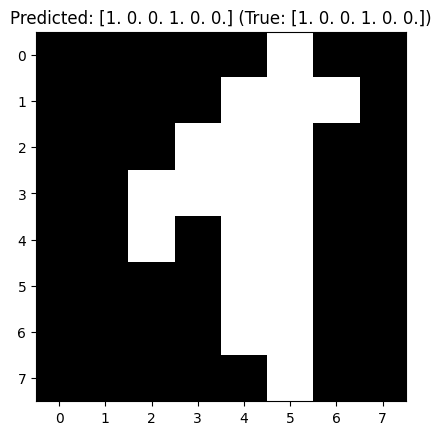

In [ ]:
input_size = X_train.shape[1]  # Image size (flattened)
nn = dna_computational_network(input_size=input_size, threshold=0.5, learning_rate=0.001)

# Train the neural network for 100 epochs
nn.train(X_train, y_train, epochs=100)

# Evaluate the model on the test set
accuracy = nn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Let's visualize a test image and its prediction
test_image = X_test[0].reshape(8, 8)  # Reshape back to 8x8 image
plt.imshow(test_image, cmap='gray')
plt.title(f"Predicted: {nn.forward(X_test[0])} (True: {y_test[0]})")
plt.show()

# Model Performance

In this section, we check our model's performance.

## Confusion Matrix

In [71]:
def ohe_to_label(ohe):
        factor = np.argmax(ohe[:3])
        remainder = np.argmax(ohe[3:])
        return 3*factor + remainder
    
def plot_confusion_matrix(y_true, y_pred, class_names):
    y_true = [ohe_to_label(i) for i in y_true]
    y_pred = [ohe_to_label(i) for i in y_pred]
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix.png')
    plt.show()

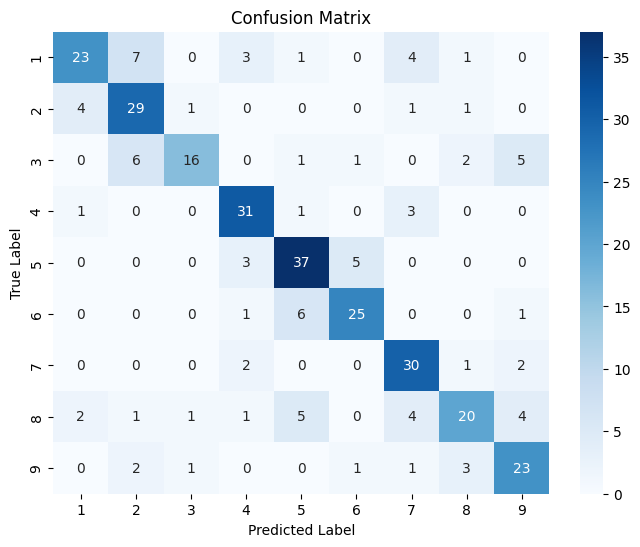

In [72]:
y_test_pred = [nn.forward(image) for image in X_test]
class_names = [f'{i}' for i in range(1, 10)]
plot_confusion_matrix(y_test, y_test_pred, class_names)

## Classification Report

In [73]:
def print_classification_report(y_true, y_pred, class_names):
    y_true = [ohe_to_label(i) for i in y_true]
    y_pred = [ohe_to_label(i) for i in y_pred]
    
    report = classification_report(y_true, y_pred, target_names=class_names)
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    # Convert to DataFrame
    report_df = pd.DataFrame(report_dict).transpose()
    # Save as CSV
    report_df.to_csv('classification_report.csv', index=True)
    print("Classification Report:\n", report)

# Example Usage:
print_classification_report(y_test, y_test_pred, class_names)

Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.59      0.67        39
           2       0.64      0.81      0.72        36
           3       0.84      0.52      0.64        31
           4       0.76      0.86      0.81        36
           5       0.73      0.82      0.77        45
           6       0.78      0.76      0.77        33
           7       0.70      0.86      0.77        35
           8       0.71      0.53      0.61        38
           9       0.66      0.74      0.70        31

    accuracy                           0.72       324
   macro avg       0.73      0.72      0.72       324
weighted avg       0.73      0.72      0.72       324



# Distributed Layer vs Accuracy

We plotted the change in accuracy as we increased the number of distributed layers.

In [ ]:
input_size = X_train.shape[1]  # Image size (flattened)
accuracies = []
for num_parallel in range(1, 10, 1):
    nn = dna_computational_network(input_size=input_size, 
                             distributed_calculation=num_parallel, threshold=0.5, learning_rate=0.001)

    # Train the neural network for 100 epochs
    nn.train(X_train, y_train, epochs=100)
    
    # Evaluate the model on the test set
    accuracy = nn.evaluate(X_test, y_test)
    accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100, Loss: 70915.0157
Epoch 2/100, Loss: 71039.3553
Epoch 3/100, Loss: 71370.9275
Epoch 4/100, Loss: 71122.2483
Epoch 5/100, Loss: 70790.6761
Epoch 6/100, Loss: 69920.2989
Epoch 7/100, Loss: 70293.3177
Epoch 8/100, Loss: 72614.3235
Epoch 9/100, Loss: 71039.3553
Epoch 10/100, Loss: 71536.7137
Epoch 11/100, Loss: 71495.2671
Epoch 12/100, Loss: 69754.5128
Epoch 13/100, Loss: 69630.1732
Epoch 14/100, Loss: 69920.2989
Epoch 15/100, Loss: 69837.4059
Epoch 16/100, Loss: 69422.9405
Epoch 17/100, Loss: 69215.7079
Epoch 18/100, Loss: 69837.4059
Epoch 19/100, Loss: 70293.3177
Epoch 20/100, Loss: 70293.3177
Epoch 21/100, Loss: 70003.1920
Epoch 22/100, Loss: 70210.4247
Epoch 23/100, Loss: 70251.8712
Epoch 24/100, Loss: 70003.1920
Epoch 25/100, Loss: 70127.5316
Epoch 26/100, Loss: 69340.0475
Epoch 27/100, Loss: 68552.5634
Epoch 28/100, Loss: 69091.3683
Epoch 29/100, Loss: 68842.6891
Epoch 30/100, Loss: 69671.6197
Epoch 31/100, Loss: 69505.8336
Epoch 32/100, Loss: 69049.9218
Epoch 33/100, Los

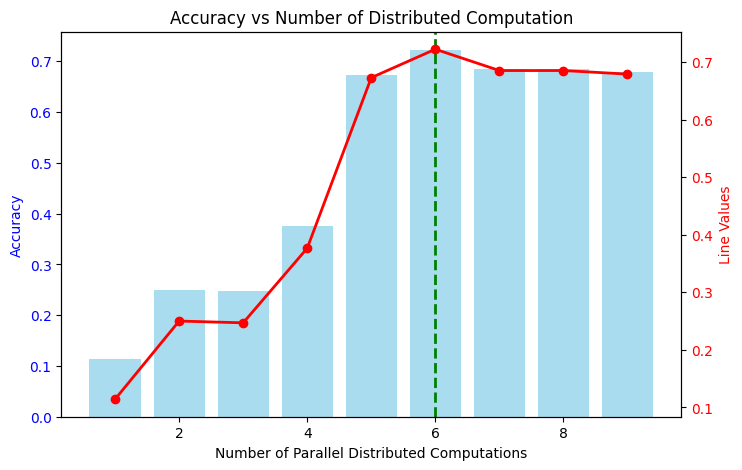

In [ ]:
# Sample data
values = accuracies
x_labels = range(1, len(values) + 1)  # X-axis labels (1 to 10)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot bar chart
ax1.bar(x_labels, values, color='skyblue', label='Bar Plot', alpha=0.7)
ax1.set_ylabel("Accuracy", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second Y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(x_labels, values, color='red', marker='o', linestyle='-', linewidth=2, label='Line Plot')
ax2.set_ylabel("Line Values", color='red')
ax2.tick_params(axis='y', labelcolor='red')
# Add a vertical line at index 6
ax1.axvline(x=6, color='green', linestyle='--', linewidth=2, label='Threshold Line')

# Title and labels
plt.title("Accuracy vs Number of Distributed Computation")
ax1.set_xlabel("Number of Parallel Distributed Computations")

# Show the graph
plt.savefig('accuracy_vs_distributed_computation.png')
plt.show()


# Conclusion

We have created a model based on DNA computation. We have achieved around 70% accuracy. We found that 6 distributed layers are the optimal number of layers that give above 70% accuracy. Beyond that, our accuracy stagnates at around 70%.